# Load Dataset

### Import Libraries

In [6]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd

### Load Historical Prices

In [7]:
# Load environment variables
load_dotenv()

# MongoDB Connection Setup
MONGO_URI = os.getenv("MONGO_URI")
if not MONGO_URI:
    raise ValueError("MONGO_URI not found in environment variables. Please check your .env file.")

DATABASE_NAME = "robo_advisor"
HISTORICAL_PRICES_COLLECTION = "historical_prices"

# Load Historical Prices
def load_historical_prices():
    client = MongoClient(MONGO_URI)
    db = client[DATABASE_NAME]
    collection = db[HISTORICAL_PRICES_COLLECTION]
    
    # Fetch all historical prices
    data = list(collection.find({}, {"_id": 0}))  # Exclude MongoDB `_id` field for simplicity
    if not data:
        print("No data found in historical_prices collection.")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} records from historical_prices collection.")
    return df

# Load and display
historical_prices_df = load_historical_prices()
historical_prices_df.head()

Loaded 667250 records from historical_prices collection.


,Date,Asset,Close,last_updated,last_updated_timestamp
0,2000-01-03,AAPL,0.999442,2024-11-13,2024-11-13 00:00:13.234
1,2000-01-04,AAPL,0.915179,2024-11-13,2024-11-13 00:00:13.234
2,2000-01-05,AAPL,0.928571,2024-11-13,2024-11-13 00:00:13.234
3,2000-01-19,AAPL,0.951451,2024-11-13,2024-11-13 00:00:13.234
4,2000-01-07,AAPL,0.888393,2024-11-13,2024-11-13 00:00:13.234


### Load Asset Metadata

In [8]:
# Asset Metadata Collection
ASSET_METADATA_COLLECTION = "asset_metadata"

# Load Asset Metadata
def load_asset_metadata():
    client = MongoClient(MONGO_URI)
    db = client[DATABASE_NAME]
    collection = db[ASSET_METADATA_COLLECTION]
    
    # Fetch all asset metadata
    data = list(collection.find({}, {"_id": 0}))  # Exclude MongoDB `_id` field for simplicity
    if not data:
        print("No data found in asset_metadata collection.")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} records from asset_metadata collection.")
    return df

# Load and display
asset_metadata_df = load_asset_metadata()
asset_metadata_df.head()

Loaded 149 records from asset_metadata collection.


,Ticker,Short Name,Long Name,Asset_Type,Sector,Industry,Exchange,Currency,Description,1Y,...,Average Dividend per Share,Dividend Frequency,Market Cap,Beta,Risk Level,Annual_Volatility,Daily_Volatility,Monthly_Volatility,Quarterly_Volatility,ticker
0,AMD,"Advanced Micro Devices, Inc.","Advanced Micro Devices, Inc.",EQUITY,Technology,Semiconductors,NMS,USD,"Advanced Micro Devices, Inc. operates as a sem...",12.411087,...,N/A,N/A,224.52 billion,1.706,High Risk,0.594082,0.037424,0.171497,0.297041,NaN
1,COKE,"Coca-Cola Consolidated, Inc.","Coca-Cola Consolidated, Inc.",EQUITY,Consumer Defensive,Beverages - Non-Alcoholic,NMS,USD,"Coca-Cola Consolidated, Inc., together with it...",75.794679,...,0.395789,Quarterly,11.04 billion,0.842,Low Risk,0.331289,0.020869,0.095635,0.165645,NaN
2,EA,Electronic Arts Inc.,Electronic Arts Inc.,EQUITY,Communication Services,Electronic Gaming & Multimedia,NMS,USD,"Electronic Arts Inc. develops, markets, publis...",23.638537,...,0.1825,Quarterly,43.71 billion,0.781,Low Risk,0.466941,0.029415,0.134794,0.233470,NaN
3,IEF,iShares 7-10 Year Treasury Bond,iShares 7-10 Year Treasury Bond ETF,ETF,N/A,N/A,NGM,USD,The underlying index measures the performance ...,1.170480,...,0.224545,Monthly,N/A,N/A,Unknown,0.069515,0.004379,0.020067,0.034757,NaN
4,JPM,JP Morgan Chase & Co.,JPMorgan Chase & Co.,EQUITY,Financial Services,Banks - Diversified,NYQ,USD,JPMorgan Chase & Co. operates as a financial s...,63.196507,...,0.370825,Quarterly,699.75 billion,1.091,Moderate Risk,5.521320,0.347810,1.593868,2.760660,NaN


In [12]:
print(asset_metadata_df.isna().sum())

Ticker                         44
Short Name                     48
Long Name                      48
Asset_Type                     48
Sector                         48
Industry                       48
Exchange                       48
Currency                       48
Description                    48
1Y                             49
3Y                             50
5Y                             53
YTD                            49
Sharpe_Ratio                   77
Sortino_Ratio                  77
Average Dividend per Share      0
Dividend Frequency              0
Market Cap                     44
Beta                           44
Risk Level                     44
Annual_Volatility              49
Daily_Volatility               49
Monthly_Volatility             49
Quarterly_Volatility           49
ticker                        105
dtype: int64


# Data Cleaning

Ensure all data is clean and consistent:
- Handle missing values (e.g., impute or drop).
- Normalize date formats (e.g., consistent Date fields).
- Standardize numerical fields (e.g., ensure returns, volatility are floats).
- Drop irrelevant or redundant fields.

### Check if there are any missing values

Visualizing missing values for 'historical_prices':
Total missing values: 885670


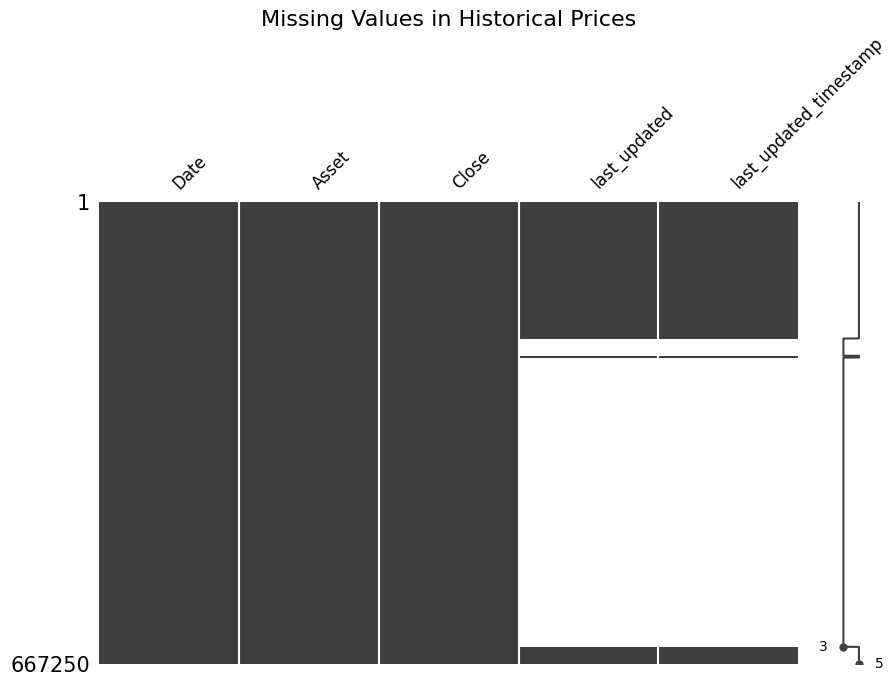


Visualizing missing values for 'asset_metadata':
Total missing values: 1216


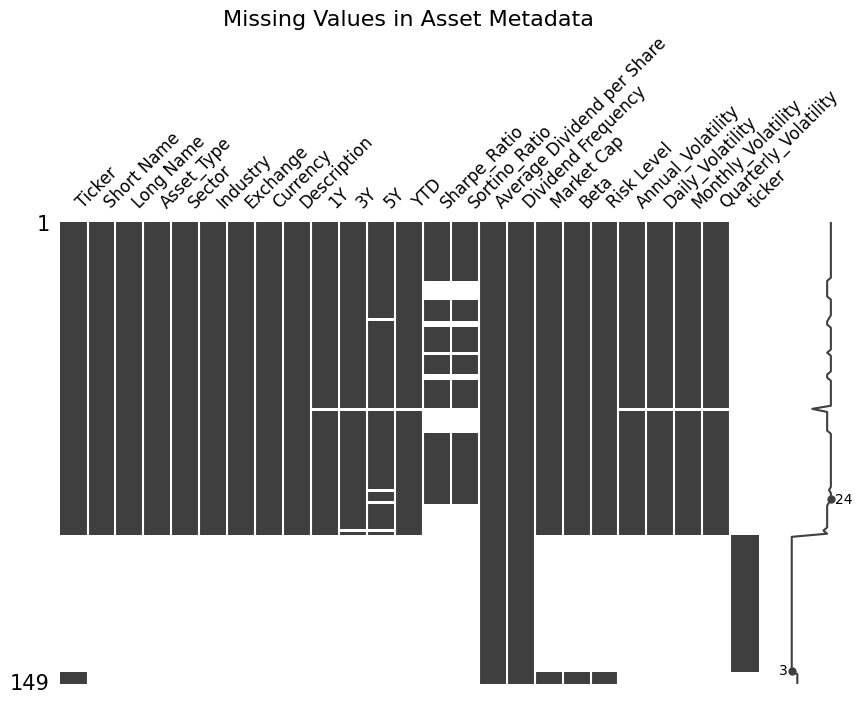

In [9]:
import missingno as msno
import matplotlib.pyplot as plt

# Function to visualize missing values
def visualize_missing_values(df, title="Missing Values"):
    if df.isnull().sum().sum() == 0:
        print("No missing values detected.")
        return
    
    print(f"Total missing values: {df.isnull().sum().sum()}")
    msno.matrix(df, figsize=(10, 6), fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()

# Visualize missing values for historical_prices
print("Visualizing missing values for 'historical_prices':")
visualize_missing_values(historical_prices_df, title="Missing Values in Historical Prices")

# Visualize missing values for asset_metadata
print("\nVisualizing missing values for 'asset_metadata':")
visualize_missing_values(asset_metadata_df, title="Missing Values in Asset Metadata")

### Normalize date formats

In [10]:
# Normalize 'Date' column in the historical_prices DataFrame
def normalize_date_format(df, date_column="Date"):
    """
    Normalize the format of the Date column in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the date column.
        date_column (str): Name of the date column to normalize.

    Returns:
        pd.DataFrame: DataFrame with normalized date format.
    """
    if date_column not in df.columns:
        print(f"Column '{date_column}' not found in DataFrame.")
        return df

    # Convert to datetime, handle errors, and format as YYYY-MM-DD
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")
    
    # Identify rows with invalid dates
    invalid_dates = df[date_column].isnull().sum()
    if invalid_dates > 0:
        print(f"Warning: {invalid_dates} invalid dates found. They have been set to NaT.")
    
    return df

# Normalize the 'Date' column in the historical_prices DataFrame
historical_prices_df = normalize_date_format(historical_prices_df, date_column="Date")

# Display sample data
print(historical_prices_df.head())

        Date Asset     Close last_updated  last_updated_timestamp
0 2000-01-03  AAPL  0.999442   2024-11-13 2024-11-13 00:00:13.234
1 2000-01-04  AAPL  0.915179   2024-11-13 2024-11-13 00:00:13.234
2 2000-01-05  AAPL  0.928571   2024-11-13 2024-11-13 00:00:13.234
3 2000-01-19  AAPL  0.951451   2024-11-13 2024-11-13 00:00:13.234
4 2000-01-07  AAPL  0.888393   2024-11-13 2024-11-13 00:00:13.234
